In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.animation as animation
import numpy as np
from neurodyn import *

from tqdm import tqdm
from scipy import stats
from pathlib import Path
from math import ceil

import matplotlib_tufte
matplotlib_tufte.setup()
from matplotlib_tufte import *

# rnn p=1

In [4]:
rnn = LowRankRNN.new_valentin(p=1, N=50_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), progress=True)

simulating LowRankRNN{N=50000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:20<00:00]


In [5]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax = 1500):
	activity = rnn.phi(res.h[:Nmax])
	idx_mapping = np.arange(len(res.h[:Nmax, -1]))

	fig, axes = plt.subplots(ncols=3, figsize=(8, 3), dpi=200,
		width_ratios=[1,30,30], layout=None)

	# neuron index

	axes[1].set_title('Unordered neuron activity', fontsize='medium')
	sc_idx = axes[1].scatter(
		idx_mapping, activity[:, 0], c=activity[:, 0],
		s=3, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1)
	axes[1].set_xlabel('Neuron index $i$')
	axes[1].set_ylim((0,1))
	axes[1].yaxis.set_visible(False)
	axes[1].spines.left.set_visible(False)
	axes[1].set_xlim((0, Nmax))
	breathe(axes[1], 'x')

	# neuron embedding

	axes[2].set_title('Neural activity in the 1D embedding', fontsize='medium')
	sc_emb = axes[2].scatter(
		rnn.F[:Nmax, 0], activity[:, 0], c=activity[:, 0],
		s=3, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1)
	axes[2].set_xlabel('Neuron embedding $z_{1i}$')
	# axes[2].set_ylabel('Activity $\\phi(h(z_{1i}))$ [Hz]')
	axes[2].set_ylim((0,1))
	axes[2].yaxis.set_visible(False)
	axes[2].spines.left.set_visible(False)
	axes[2].set_xlim((-3, 3))
	axes[2].set_xticks([-3, 0, 3])
	breathe(axes[2], 'x')

	fig.colorbar(
		sc_emb, cax=axes[0],
		location='left',
		label='Activity $\\phi(h(z_{1i}))$ [Hz]')

	fig.subplots_adjust(wspace=0.2)
	plt.draw()  # force initialization draw
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the scatters
			sc_idx.set_offsets(np.vstack((idx_mapping, activity[:, idt])).T)
			sc_idx.set_array(activity[:, idt])
			sc_emb.set_offsets(np.vstack((rnn.F[:Nmax, 0], activity[:, idt])).T)
			sc_emb.set_array(activity[:, idt])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		# plt.show()
		plt.close()

anim(rnn, res, 'animations/embedding_p=1.mp4', Nmax=1000, time_stride=5)

100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


# rnn p=2

In [53]:
rnn = LowRankRNN.new_valentin(p=2, N=100_000, random_state=42, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), progress=True)

simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:22<00:00]


In [54]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax = 1500):
	activity = rnn.phi(res.h[:Nmax])

	fig, axes = plt.subplots(ncols=2, figsize=(4, 3), dpi=200,
		width_ratios=[30, 1], layout=None)

	# neuron embedding

	ss = axes[0].get_subplotspec()
	axes[0].remove()
	axes[0] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[0].set_proj_type('ortho')

	axes[0].set_title('Neural activity in the 2D embedding', fontsize='medium')
	axes[0].scatter(
		rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], np.zeros_like(activity[:, 0]),
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on the floor
	sc_proj1 = axes[0].scatter(
		rnn.F[:Nmax, 0], np.full(Nmax, 4), activity[:Nmax, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	sc_proj2 = axes[0].scatter(
		np.full(Nmax, 4), rnn.F[:Nmax, 1], activity[:Nmax, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	sc_emb = axes[0].scatter(
		rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], activity[:Nmax, 0], c=activity[:, 0],
		s=3, alpha=1, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1
	)  # the full projection
	axes[0].set_xlabel('$z_{1i}$')
	axes[0].set_ylabel('$z_{2i}$')
	axes[0].set_xlim((-4, 4))
	axes[0].set_ylim((-4, 4))
	axes[0].set_zlim((0,1))
	axes[0].view_init(azim=180+45)

	# axes[0].yaxis.set_visible(False)
	# axes[0].spines.left.set_visible(False)
	# breathe(axes[0], 'x')

	fig.colorbar(
		sc_emb, cax=axes[1],
		location='right',
		label='Activity $\\phi(h(z_{1i},z_{2i}))$ [Hz]')

	fig.subplots_adjust(wspace=0.2)
	for _ in range(20):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the scatters
			sc_emb.set_offsets(np.vstack((rnn.F[:Nmax, 0], rnn.F[:Nmax, 1])).T)
			sc_emb.set_3d_properties(activity[:Nmax, idt].T, 'z')
			sc_emb.set_array(activity[:Nmax, idt])
			# update the shadow z1
			sc_proj1.set_offsets(np.vstack((rnn.F[:Nmax, 0], np.full(Nmax, 4))).T)
			sc_proj1.set_3d_properties(activity[:Nmax, idt].T, 'z')
			# update the shadow z2
			sc_proj2.set_offsets(np.vstack((np.full(Nmax, 4), rnn.F[:Nmax, 1])).T)
			sc_proj2.set_3d_properties(activity[:Nmax, idt].T, 'z')

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		# plt.show()
		plt.close()

anim(rnn, res, 'animations/embedding_p=2.mp4', Nmax=5000, time_stride=5)

100%|██████████| 82/82 [00:34<00:00,  2.40it/s]


# p=2 cycling

In [70]:
nrec = 6
rnn = LowRankCyclingRNN.new_sampled_valentin(
	phi=sigmoid, mapping_samples=ReshapeMapping.new_nrec(nrec=nrec).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=6, shift=1
)
res = rnn.simulate(rnn.F[:, 0], (0, 60), progress=True, cache=True)

simulating LowRankCyclingRNN{N=4096, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=60.000 of 60 [00:04<00:00]


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'Latent trajectory'}, xlabel='Latent $\\kappa_1(t)$', ylabel='Latent $\\kappa_2(t)$'>)

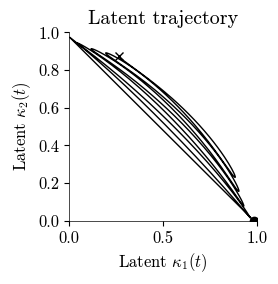

In [71]:
plot_overlap_phase2D(rnn, res)

In [91]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1):
	activity = rnn.phi(res.h)

	fig, axes = plt.subplots(ncols=3, figsize=(8, 3), dpi=200,
		width_ratios=[1, 30, 30], layout='constrained')

	# neuron embedding

	ss = axes[1].get_subplotspec()
	axes[1].remove()
	axes[1] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[1].set_proj_type('ortho')

	shape = (2**nrec, 2**nrec)

	axes[1].set_title('Neural activity in the 2D embedding', fontsize='medium')
	sc_proj1 = axes[1].scatter(
		rnn.F[:, 0], np.full(rnn.N, 3), activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	sc_proj2 = axes[1].scatter(
		np.full(rnn.N, 3), rnn.F[:, 1], activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2

	surf_emb = axes[1].plot_surface(
		rnn.F[:, 0].reshape(shape), rnn.F[:, 1].reshape(shape), activity[:, 0].reshape(shape),
		cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
	)
	axes[1].set_xlabel('$z_1$')
	axes[1].set_ylabel('$z_2$')
	axes[1].set_xlim((-3, 3))
	axes[1].set_ylim((-3, 3))
	axes[1].set_zlim((0,1))
	axes[1].view_init(azim=180+45)

	fig.colorbar(
		surf_emb, cax=axes[0],
		location='left',
		label='Activity $\\phi(h(z_1,z_2))$ [Hz]')

	kappa = projection(rnn, res.h)
	lat_line = axes[2].plot(*kappa[:, :1], color='black', clip_on=False)[0]
	lat_cur = axes[2].plot(*kappa[:, :1], 'o', color='black', clip_on=False)[0]
	axes[2].set_xlabel('$\\kappa_1$'); axes[2].set_ylabel('$\\kappa_2$');
	axes[2].set_xlim((0, 1)); axes[2].set_ylim((0, 1));
	axes[2].set_title('Latent trajectory', fontsize='medium')
	axes[2].set_aspect('equal')
	breathe(axes[2])

	# fig.subplots_adjust(wspace=0.2)
	for _ in range(20):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	
	# plt.show()
	# return

	things = dict(surf_emb=surf_emb)  # need a dict to hold a reference, because we re-assign. thank you, Python nya

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the surface
			things['surf_emb'].remove()
			things['surf_emb'] = axes[1].plot_surface(
				rnn.F[:, 0].reshape(shape), rnn.F[:, 1].reshape(shape), activity[:, idt].reshape(shape),
				cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
			)

			# update the shadow z1
			sc_proj1.set_offsets(np.vstack((rnn.F[:, 0], np.full(rnn.N, 3))).T)
			sc_proj1.set_3d_properties(activity[:, idt].T, 'z')
			# update the shadow z2
			sc_proj2.set_offsets(np.vstack((np.full(rnn.N, 3), rnn.F[:, 1])).T)
			sc_proj2.set_3d_properties(activity[:, idt].T, 'z')

			# update the latent trajectory
			lat_line.set_data(*kappa[:, :idt+1])
			lat_cur.set_data(*kappa[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()

anim(rnn, res, 'animations/embedding_p=2_cycling.mp4', time_stride=3)

100%|██████████| 202/202 [01:55<00:00,  1.75it/s]


# coarse-graining p=2 (attempt 1)

In [47]:
nrec = 8
# we use less nrec for the non-downsampled, because 2^6 is already "converged",
# and using 2^8 doesn't change anything, just makes things slower
nrec0 = 6

rnn0 = LowRankCyclingRNN.new_sampled_valentin(
	phi=sigmoid, mapping_samples=ReshapeMapping.new_nrec(nrec=nrec0).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=6, shift=1
)
res0 = rnn0.simulate(rnn0.F[:, 0], (0, 10), progress=True, cache=False)

mapping_random = RandomMapping.new_nrec(nrec)
rnn_random = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_random.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_random = rnn_random.simulate(rnn_random.F[:, 0], (0, 10), progress=True, cache=False)

mapping_column = ColumnMapping.new_nrec(nrec)
rnn_column = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_column.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_column = rnn_column.simulate(rnn_column.F[:, 0], (0, 10), progress=True, cache=False)

mapping_z = ZMapping.new_nrec(nrec)
rnn_z = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_z.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_z = rnn_z.simulate(rnn_z.F[:, 0], (0, 10), progress=True, cache=False)

simulating LowRankCyclingRNN{N=4096, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]


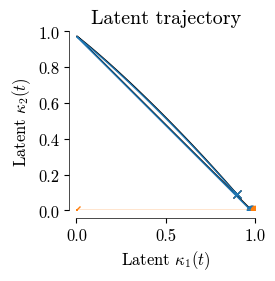

In [48]:
figax = plot_overlap_phase2D(rnn0, res0);
figax = plot_overlap_phase2D(rnn_z, res_z, figax=figax);
figax = plot_overlap_phase2D(rnn_column, res_column, figax=figax);
breathe(figax[1])
# plt.show()
plt.show()

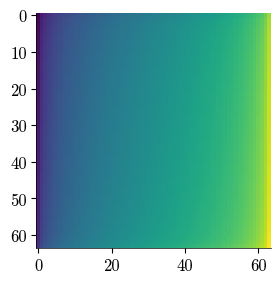

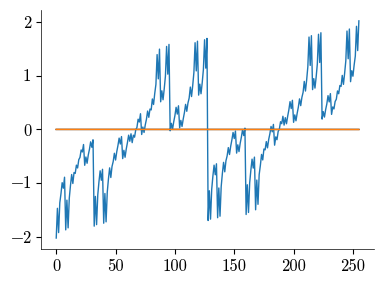

In [49]:
# and now, for the dirtiest hack i ever wrote
# because trying to log the I_rec that's also called by scipy's ivp solve is a massive headache
# dear Deities that reign our forsaken world, please look away
# coming back to this hours later, i made it even worse,
# sometimes you just have to accept that some code is going to be terrible
def hack_I_rec(rnn, res, mapping = None):
	I_rec = np.zeros_like(res.h)
	nrec = int(np.emath.logn(4, len(rnn.F)))

	if mapping is not None:
		rnn_ = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
			phi=rnn.phi, mapping_samples=mapping.inverse_samples(),
			I_ext=rnn.I_ext, exclude_self_connections=rnn.exclude_self_connections, delta=rnn.delta, shift=rnn.shift,
		).downsampled())
	else:
		rnn_ = LowRankCyclingRNN.new_sampled_valentin(
			phi=rnn.phi, mapping_samples=ReshapeMapping.new_nrec(nrec=nrec0).inverse_samples(),
			I_ext=rnn.I_ext, exclude_self_connections=rnn.exclude_self_connections, delta=rnn.delta, shift=rnn.shift,
		)
	assert rnn_.N == rnn.N  # omg such safety
	didt_lag = int((res.t.max() - res.t.min())/rnn.delta)

	for idt in range(res.h.shape[1]):
		idt_lag = max(0, idt - didt_lag)
		# this is absolutely terrible, i know what im doing, but please, never do this
		rnn_.h_lagging = LaggingFunction([0], [res.h[:, idt_lag]], rnn_.delta)
		I_rec[:, idt] = rnn_.I_rec(0, res.h[:, idt])

	return I_rec

# seems like the hack works UwU
plt.imshow(hack_I_rec(rnn0, res0)[:, 2].reshape(2**nrec0, 2**nrec0))
plt.show()
plt.plot(hack_I_rec(rnn_random, res_random, mapping_random)[:, 2])
plt.plot(hack_I_rec(rnn_z, res_z, mapping_z)[:, 2])
plt.plot(hack_I_rec(rnn_column, res_column, mapping_column)[:, 2]);

In [50]:
def anim(outpath: Path, time_stride: int = 1):
	activity0 = rnn0.phi(res0.h)
	activity_random = rnn_random.phi(res_random.h)
	activity_column = rnn_column.phi(res_column.h)
	activity_z = rnn_z.phi(res_z.h)
	I_rec0 = hack_I_rec(rnn0, res0)
	I_rec_random = hack_I_rec(rnn_random, res_random, mapping_random)
	I_rec_column = hack_I_rec(rnn_column, res_column, mapping_column)
	I_rec_z = hack_I_rec(rnn_z, res_z, mapping_z)
	kappa0 = projection(rnn0, res0.h)
	kappa_random = projection(rnn_random, res_random.h)
	kappa_column = projection(rnn_column, res_column.h)
	kappa_z = projection(rnn_z, res_z.h)
	things = {}

	fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(4*3-3, 3*4), dpi=200, layout=None)

	# neuron embedding, 2D embedding

	ss = axes[0, 0].get_subplotspec()
	axes[0, 0].remove()
	axes[0, 0] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[0, 0].set_proj_type('ortho')
	things['sc_proj1'] = axes[0, 0].scatter(
		rnn0.F[:, 0], np.full(rnn0.N, 3), activity0[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	things['sc_proj2'] = axes[0, 0].scatter(
		np.full(rnn0.N, 3), rnn0.F[:, 1], activity0[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	things['surf_emb'] = axes[0, 0].plot_surface(
		rnn0.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn0.F[:, 1].reshape((2**nrec0, 2**nrec0)), activity0[:, 0].reshape((2**nrec0, 2**nrec0)),
		cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
	)
	axes[0, 0].set_xlabel('$z_1$')
	axes[0, 0].set_ylabel('$z_2$')
	axes[0, 0].set_xlim((-3, 3))
	axes[0, 0].set_ylim((-3, 3))
	axes[0, 0].set_zlim((0,1))
	axes[0, 0].view_init(azim=180+45)

	# recurrent currents, 2D embedding

	ss = axes[0, 1].get_subplotspec()
	axes[0, 1].remove()
	axes[0, 1] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[0, 1].set_proj_type('ortho')
	things['sc_proj1_I_rec'] = axes[0, 1].scatter(
		rnn0.F[:, 0], np.full(rnn0.N, 3), I_rec0[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	things['sc_proj2_I_rec'] = axes[0, 1].scatter(
		np.full(rnn0.N, 3), rnn0.F[:, 1], I_rec0[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	things['surf_emb_I_rec'] = axes[0, 1].plot_surface(
		rnn0.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn0.F[:, 1].reshape((2**nrec0, 2**nrec0)), I_rec0[:, 0].reshape((2**nrec0, 2**nrec0)),
		cmap=cmap_pan, vmin=-2, vmax=2, rasterized=True,
	)
	axes[0, 1].set_xlabel('$z_1$')
	axes[0, 1].set_ylabel('$z_2$')
	axes[0, 1].set_xlim((-3, 3))
	axes[0, 1].set_ylim((-3, 3))
	axes[0, 1].set_zlim((-2.5,2.5))
	axes[0, 1].view_init(azim=180+45)

	# kappa, 2D embedding

	things['lat_line'] = axes[0, 2].plot(*kappa0[:, :1], color='black', clip_on=False)[0]
	things['lat_cur'] = axes[0, 2].plot(*kappa0[:, :1], 'o', color='black', clip_on=False)[0]
	axes[0, 2].set_xlabel('$\\kappa_1$'); axes[0, 2].set_ylabel('$\\kappa_2$');
	axes[0, 2].set_xlim((0, 1)); axes[0, 2].set_ylim((0, 1));
	axes[0, 2].set_aspect('equal')
	breathe(axes[0, 2])

	thingsnya = {}

	for irow, name, rnn, res, activity, I_rec, kappa in [
		(1, 'random', rnn_random, res_random, activity_random, I_rec_random, kappa_random),
		(2, 'column', rnn_column, res_column, activity_column, I_rec_column, kappa_column),
		(3, 'z', rnn_z, res_z, activity_z, I_rec_z, kappa_z),
	]:
		# neuron embedding

		thingsnya['sc_' + name] = axes[irow, 0].scatter(
			np.arange(len(rnn.F)) / len(rnn.F), activity[:, 0], c=activity[:, 0],
			cmap=cmap_bi, vmin=0, vmax=1, s=10, clip_on=False)
		axes[irow, 0].set(
			xlim=(0,1), ylim=(0,1),
			xlabel='$\\alpha$', ylabel='$\\phi(\\tilde h(\\alpha))$'
		)
		breathe(axes[irow, 0])

		# recurrent currents

		thingsnya['sc_' + name + '_I_rec'] = axes[irow, 1].scatter(
			np.arange(len(rnn.F)) / len(rnn.F), I_rec[:, 0], c=I_rec[:, 0],
			cmap=cmap_pan, vmin=-2, vmax=2, s=10, clip_on=False)
		axes[irow, 1].set(
			xlim=(0,1), ylim=(-2.5, 2.5),
			xlabel='$\\alpha$', ylabel='$I^{\\mathrm{rec}}(\\alpha)$'
		)
		breathe(axes[irow, 1])

		# kappa

		thingsnya['lat_line_' + name] = axes[irow, 2].plot(*kappa[:, :1], color='black', clip_on=False)[0]
		thingsnya['lat_cur_' + name] = axes[irow, 2].plot(*kappa[:, :1], 'o', color='black', clip_on=False)[0]
		axes[irow, 2].set_xlabel('$\\kappa_1$'); axes[irow, 2].set_ylabel('$\\kappa_2$');
		axes[irow, 2].set_xlim((0, 1)); axes[irow, 2].set_ylim((0, 1));
		axes[irow, 2].set_aspect('equal')
		breathe(axes[irow, 2])

	add_headers(fig, axes.flat, col_headers=['Neural activity', 'Recurrent currents', 'Latent trajectory'], col_pad=8)
	add_headers(fig, axes.flat, row_headers=['', 'To $[0,1]$ with random', 'To $[0,1]$ with Column', 'To $[0,1]$ with Z'], row_pad=10)

	# fig.subplots_adjust(wspace=0.2)
	for _ in range(5):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the surface
			things['surf_emb'].remove()
			things['surf_emb'] = axes[0, 0].plot_surface(
				rnn0.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn0.F[:, 1].reshape((2**nrec0, 2**nrec0)), activity0[:, idt].reshape((2**nrec0, 2**nrec0)),
				cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
			)

			# update the shadow z1
			things['sc_proj1'].set_offsets(np.vstack((rnn0.F[:, 0], np.full(rnn0.N, 3))).T)
			things['sc_proj1'].set_3d_properties(activity0[:, idt].T, 'z')
			# update the shadow z2
			things['sc_proj2'].set_offsets(np.vstack((np.full(rnn0.N, 3), rnn0.F[:, 1])).T)
			things['sc_proj2'].set_3d_properties(activity0[:, idt].T, 'z')

			# update the surface
			things['surf_emb_I_rec'].remove()
			things['surf_emb_I_rec'] = axes[0, 1].plot_surface(
				rnn0.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn0.F[:, 1].reshape((2**nrec0, 2**nrec0)), I_rec0[:, idt].reshape((2**nrec0, 2**nrec0)),
				cmap=cmap_pan, vmin=-2, vmax=2, rasterized=True,
			)

			# update the shadow z1
			things['sc_proj1_I_rec'].set_offsets(np.vstack((rnn0.F[:, 0], np.full(rnn0.N, 3))).T)
			things['sc_proj1_I_rec'].set_3d_properties(I_rec0[:, idt].T, 'z')
			# update the shadow z2
			things['sc_proj2_I_rec'].set_offsets(np.vstack((np.full(rnn0.N, 3), rnn0.F[:, 1])).T)
			things['sc_proj2_I_rec'].set_3d_properties(I_rec0[:, idt].T, 'z')

			# update the latent trajectory
			things['lat_line'].set_data(*kappa0[:, :idt+1])
			things['lat_cur'].set_data(*kappa0[:, idt:idt+1])

			for irow, name, rnn, res, activity, I_rec, kappa in [
				(1, 'random', rnn_random, res_random, activity_random, I_rec_random, kappa_random),
				(2, 'column', rnn_column, res_column, activity_column, I_rec_column, kappa_column),
				(3, 'z', rnn_z, res_z, activity_z, I_rec_z, kappa_z),
			]:
				thingsnya['sc_' + name].set_offsets(np.vstack((np.arange(len(rnn.F)) / len(rnn.F), activity[:, idt])).T)
				thingsnya['sc_' + name].set_array(activity[:, idt])

				thingsnya['sc_' + name + '_I_rec'].set_offsets(np.vstack((np.arange(len(rnn.F)) / len(rnn.F), I_rec[:, idt])).T)
				thingsnya['sc_' + name + '_I_rec'].set_array(I_rec[:, idt])

				thingsnya['lat_line_' + name].set_data(*kappa[:, :idt+1])
				thingsnya['lat_cur_' + name].set_data(*kappa[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t)-1, time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()

# END lmao

anim('animations/coarse_graining_p=2.mp4', time_stride=1)

 99%|█████████▉| 102/103 [02:38<00:01,  1.55s/it]


# coarse-graining p=2

In [63]:
nrec = 8
# we use less nrec for the non-downsampled, because 2^6 is already "converged",
# and using 2^8 doesn't change anything, just makes things slower
nrec0 = 6

rnn0 = LowRankCyclingRNN.new_sampled_valentin(
	phi=sigmoid, mapping_samples=ReshapeMapping.new_nrec(nrec=nrec0).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=6, shift=1
)
res0 = rnn0.simulate(rnn0.F[:, 0], (0, 50), progress=True, cache=False)

mapping_random = RandomMapping.new_nrec(nrec)
rnn_random = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_random.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_random = rnn_random.simulate(rnn_random.F[:, 0], (0, 6), progress=True, cache=False)

mapping_column = ColumnMapping.new_nrec(nrec)
rnn_column = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_column.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_column = rnn_column.simulate(rnn_column.F[:, 0], (0, 6), progress=True, cache=False)

mapping_z = ZMapping.new_nrec(nrec)
rnn_z = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	mapping_samples=mapping_z.inverse_samples(),
	phi=rnn0.phi, I_ext=rnn0.I_ext, exclude_self_connections=rnn0.exclude_self_connections,
	delta=rnn0.delta, shift=rnn0.shift
).downsampled())
res_z = rnn_z.simulate(rnn_z.F[:, 0], (0, 50), progress=True, cache=False)

simulating LowRankCyclingRNN{N=4096, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:04<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=6.000 of 6 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=6.000 of 6 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]


In [60]:
def anim_mapping(rnn, res, mapping, outpath: Path, time_stride: int = 1):
	activity = rnn.phi(res.h)
	I_rec = hack_I_rec(rnn, res, mapping)
	kappa = projection(rnn, res.h)

	fig, axes = plt.subplots(ncols=3, figsize=(4*3-3, 3*1), dpi=200, layout='constrained')

	# neuron embedding

	sc = axes[0].scatter(
		np.arange(len(rnn.F)) / len(rnn.F), activity[:, 0], c=activity[:, 0],
		cmap=cmap_bi, vmin=0, vmax=1, s=10, clip_on=False)
	axes[0].set(
		xlim=(0,1), ylim=(0,1),
		xlabel='$\\alpha$', ylabel='$\\phi(\\tilde h(\\alpha))$'
	)
	breathe(axes[0])

	# recurrent currents

	sc_I_rec = axes[1].scatter(
		np.arange(len(rnn.F)) / len(rnn.F), I_rec[:, 0], c=I_rec[:, 0],
		cmap=cmap_pan, vmin=-2, vmax=2, s=10, clip_on=False)
	axes[1].set(
		xlim=(0,1), ylim=(-2.5, 2.5),
		xlabel='$\\alpha$', ylabel='$I^{\\mathrm{rec}}(\\alpha)$'
	)
	breathe(axes[1])

	# kappa

	lat_line = axes[2].plot(*kappa[:, :1], color='black', clip_on=False)[0]
	lat_cur = axes[2].plot(*kappa[:, :1], 'o', color='black', clip_on=False)[0]
	axes[2].set_xlabel('$\\kappa_1$'); axes[2].set_ylabel('$\\kappa_2$');
	axes[2].set_xlim((0, 1)); axes[2].set_ylim((0, 1));
	axes[2].set_aspect('equal')
	breathe(axes[2])

	add_headers(fig, axes.flat, col_headers=['Neural activity', 'Recurrent currents', 'Latent trajectory'], col_pad=8)

	# fig.subplots_adjust(wspace=0.2)
	for _ in range(5):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			sc.set_offsets(np.vstack((np.arange(len(rnn.F)) / len(rnn.F), activity[:, idt])).T)
			sc.set_array(activity[:, idt])

			sc_I_rec.set_offsets(np.vstack((np.arange(len(rnn.F)) / len(rnn.F), I_rec[:, idt])).T)
			sc_I_rec.set_array(I_rec[:, idt])

			lat_line.set_data(*kappa[:, :idt+1])
			lat_cur.set_data(*kappa[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t)-1, time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()


In [64]:
anim_mapping(rnn_random, res_random, mapping_random, 'animations/coarse_graining_p=2_random.mp4', time_stride=1)

 98%|█████████▊| 62/63 [00:32<00:00,  1.88it/s]


In [65]:
anim_mapping(rnn_column, res_column, mapping_column, 'animations/coarse_graining_p=2_column.mp4', time_stride=1)

 98%|█████████▊| 62/63 [00:23<00:00,  2.63it/s]


In [66]:
anim_mapping(rnn_z, res_z, mapping_z, 'animations/coarse_graining_p=2_z.mp4', time_stride=5)

100%|██████████| 102/102 [00:39<00:00,  2.58it/s]


In [71]:
def anim2d(rnn, res, outpath: Path, time_stride: int = 1):
	activity = rnn.phi(res.h)
	I_rec = hack_I_rec(rnn, res)
	kappa = projection(rnn, res.h)
	things = {}

	fig, axes = plt.subplots(ncols=3, figsize=(4*3-3, 3*1), dpi=200, layout=None)

	# neuron embedding, 2D embedding

	ss = axes[0].get_subplotspec()
	axes[0].remove()
	axes[0] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[0].set_proj_type('ortho')

	things['sc_proj1'] = axes[0].scatter(
		rnn.F[:, 0], np.full(rnn.N, 3), activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	things['sc_proj2'] = axes[0].scatter(
		np.full(rnn.N, 3), rnn.F[:, 1], activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	things['surf_emb'] = axes[0].plot_surface(
		rnn.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn.F[:, 1].reshape((2**nrec0, 2**nrec0)), activity[:, 0].reshape((2**nrec0, 2**nrec0)),
		cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
	)
	axes[0].set_xlabel('$z_1$')
	axes[0].set_ylabel('$z_2$')
	axes[0].set_xlim((-3, 3))
	axes[0].set_ylim((-3, 3))
	axes[0].set_zlim((0,1))
	axes[0].view_init(azim=180+45)

	# recurrent currents, 2D embedding

	ss = axes[1].get_subplotspec()
	axes[1].remove()
	axes[1] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[1].set_proj_type('ortho')
	things['sc_proj1_I_rec'] = axes[1].scatter(
		rnn.F[:, 0], np.full(rnn.N, 3), I_rec[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	things['sc_proj2_I_rec'] = axes[1].scatter(
		np.full(rnn.N, 3), rnn.F[:, 1], I_rec[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	things['surf_emb_I_rec'] = axes[1].plot_surface(
		rnn.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn.F[:, 1].reshape((2**nrec0, 2**nrec0)), I_rec[:, 0].reshape((2**nrec0, 2**nrec0)),
		cmap=cmap_pan, vmin=-2, vmax=2, rasterized=True,
	)
	axes[1].set_xlabel('$z_1$')
	axes[1].set_ylabel('$z_2$')
	axes[1].set_xlim((-3, 3))
	axes[1].set_ylim((-3, 3))
	axes[1].set_zlim((-2.5,2.5))
	axes[1].view_init(azim=180+45)

	# kappa, 2D embedding

	things['lat_line'] = axes[2].plot(*kappa[:, :1], color='black', clip_on=False)[0]
	things['lat_cur'] = axes[2].plot(*kappa[:, :1], 'o', color='black', clip_on=False)[0]
	axes[2].set_xlabel('$\\kappa_1$'); axes[2].set_ylabel('$\\kappa_2$');
	axes[2].set_xlim((0, 1)); axes[2].set_ylim((0, 1));
	axes[2].set_aspect('equal')
	breathe(axes[2])


	add_headers(fig, axes.flat, col_headers=['Neural activity', 'Recurrent currents', 'Latent trajectory'], col_pad=8)
	add_headers(fig, axes.flat, row_headers=['', 'To $[0,1]$ with random', 'To $[0,1]$ with Column', 'To $[0,1]$ with Z'], row_pad=10)

	# fig.subplots_adjust(wspace=0.2)
	for _ in range(20):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the surface
			things['surf_emb'].remove()
			things['surf_emb'] = axes[0].plot_surface(
				rnn.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn.F[:, 1].reshape((2**nrec0, 2**nrec0)), activity[:, idt].reshape((2**nrec0, 2**nrec0)),
				cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
			)

			# update the shadow z1
			things['sc_proj1'].set_offsets(np.vstack((rnn.F[:, 0], np.full(rnn.N, 3))).T)
			things['sc_proj1'].set_3d_properties(activity[:, idt].T, 'z')
			# update the shadow z2
			things['sc_proj2'].set_offsets(np.vstack((np.full(rnn.N, 3), rnn.F[:, 1])).T)
			things['sc_proj2'].set_3d_properties(activity[:, idt].T, 'z')

			# update the surface
			things['surf_emb_I_rec'].remove()
			things['surf_emb_I_rec'] = axes[1].plot_surface(
				rnn.F[:, 0].reshape((2**nrec0, 2**nrec0)), rnn.F[:, 1].reshape((2**nrec0, 2**nrec0)), I_rec[:, idt].reshape((2**nrec0, 2**nrec0)),
				cmap=cmap_pan, vmin=-2, vmax=2, rasterized=True,
			)

			# update the shadow z1
			things['sc_proj1_I_rec'].set_offsets(np.vstack((rnn.F[:, 0], np.full(rnn.N, 3))).T)
			things['sc_proj1_I_rec'].set_3d_properties(I_rec[:, idt].T, 'z')
			# update the shadow z2
			things['sc_proj2_I_rec'].set_offsets(np.vstack((np.full(rnn.N, 3), rnn.F[:, 1])).T)
			things['sc_proj2_I_rec'].set_3d_properties(I_rec[:, idt].T, 'z')

			# update the latent trajectory
			things['lat_line'].set_data(*kappa[:, :idt+1])
			things['lat_cur'].set_data(*kappa[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t)-1, time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()

# END lmao

anim2d(rnn0, res0, 'animations/coarse_graining_p=2_original.mp4', time_stride=5)

100%|██████████| 102/102 [01:14<00:00,  1.37it/s]
